In [1]:
from astropy.io import fits

import time, glob, pickle, cv2
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import stats
from astropy.convolution import Gaussian2DKernel,convolve
import scipy.ndimage as snd
import sep,scipy.stats

from scipy.optimize import curve_fit

In [2]:
def mychi(x,ampfoo,a,b,c):
    ychi=ampfoo*scipy.stats.chi2.pdf(x, a,b,c)
    return ychi


def gains_from_stdflat_chi(medflat,stdflat,stdbias,dedgexy=(20,50),mask=None,dskipxy=(10,10),
                       doplots=False,gainminmax=(.7,1.8),crdnoise=2,nbins=1000):
    dat=stdflat
    gainmin,gainmax=gainminmax
    foogains=np.ones(16)
    ysfoo,xsfoo=dat.shape
    if mask.any==None: mask=np.ones(dat.shape)
    yamp,xamp=int(ysfoo/2),int(xsfoo/8)
    dedgex,dedgey=dedgexy
    dskipx,dskipy=dskipxy
    ilist=np.arange(1,8)
    #random.shuffle(ilist)
    ifoo=0
    for j in range(2):
        for i in range(8):
            xmin,xmax,ymin,ymax=xamp*i,xamp*(i+1),yamp*j,yamp*(j+1)
            medamp=medflat[ymin:ymax,xmin:xmax]
            stdamp=stdflat[ymin:ymax,xmin:xmax]
            stdbiasamp=stdbias[ymin:ymax,xmin:xmax]
            maskamp=mask[ymin:ymax,xmin:xmax]
            gmask=np.where(maskamp==1)
            #medmean,medmed,medstd=stats.sigma_clipped_stats(medamp)
            #stdmean,stdmed,stdstd=stats.sigma_clipped_stats(stdamp)
            gainvals=(2.*medamp/(stdamp**2-crdnoise*stdbiasamp**2))[gmask]
            gainmean,gainmed,gainstd=stats.sigma_clipped_stats(gainvals)
            n,b=np.histogram(gainvals.flatten(),bins=nbins,range=[gainmin,gainmax])
            b=b[:-1]+.5*(b[1]-b[0])
            
            #plt.plot(b,n,label=str((i,j)))
            plt.legend()
            #params,cov=curve_fit(myskew,b,n,sigma=10.*(n+1)**-.5,p0=[2.,10.3,10.2,20000.],maxfev = 100000)
            params,cov=curve_fit(mychi,b,n,sigma=1.*(n+1)**-.5,p0=[3000.,10,5,1],maxfev = 100000)
            plt.subplot(2,2,j*2+1)
            
            plt.plot(b,n,lw=3,label=str((i,j)))
            plt.plot(b,mychi(b,*params),color='k',alpha=.6,lw=1)
            #plt.plot(b,myskew(b,*params),color='k',alpha=.4,lw=2)
            #p0=[2.8,.83,.079,8000.]
            yfoo=mychi(b,*params)
            foogains[ifoo]=b[np.where(yfoo==yfoo.max())[0]]
            ifoo+=1
            print(params,len(gmask[0])/(xamp*yamp))
            
    return foogains,n,b


def apply_gains_from_stdflat(foomos,foogains):
    ysfoo,xsfoo=foomos.shape
    outmos=np.empty(foomos.shape)
    yamp,xamp=int(ysfoo/2),int(xsfoo/8)
    #dedgex,dedgey=dedgexy
    #dskipx,dskipy=dskipxy
    #random.shuffle(ilist)
    ifoo=0
    for j in range(2):
        for i in range(8):
            y0,y1,x0,x1=yamp*j,yamp*(j+1),xamp*i,xamp*(i+1)
            outmos[y0:y1,x0:x1]=foomos[y0:y1,x0:x1]*foogains[ifoo]
            ifoo+=1
    return outmos

In [6]:
rootdir='/home/andrew/work/ccd/20210718-ultra_flat_illuminator/'

In [7]:
sensnum='S??'
fitslist=np.sort(glob.glob(rootdir+'master/'+sensnum+'*.fits'))
nfits=len(fitslist)
print(nfits,"files \n",fitslist[:10],fitslist[-10:],fitslist[int(nfits/2)])

72 files 
 ['/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S00_hip.fits'
 '/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S00_mask.fits'
 '/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S00_meanbias.fits'
 '/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S00_meanflat.fits'
 '/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S00_medbias.fits'
 '/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S00_medflat.fits'
 '/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S00_stdbias.fits'
 '/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S00_stdflat.fits'
 '/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S01_hip.fits'
 '/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S01_mask.fits'] ['/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S21_stdbias.fits'
 '/home/andrew/work/ccd/20210718-ultra_flat_illuminator/master/S21_stdflat.fits'
 '/home/andrew/work/ccd/2021

In [8]:
fs=18

No handles with labels found to put in legend.


[1.88643605e+04 5.07044298e+01 1.50659470e+01 2.38963635e-01] 0.8456434184675835
[1.93758033e+04 5.07241983e+01 1.50332889e+01 2.38331017e-01] 0.8680943025540275


/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently

[1.89379891e+04 5.79117296e+01 1.42963243e+01 2.23426273e-01] 0.8490343811394891
[1.93718640e+04 5.26850002e+01 1.49020775e+01 2.33174063e-01] 0.8695599214145383


/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[1.91849329e+04 5.25154873e+01 1.48981565e+01 2.34247127e-01] 0.8600550098231827
[1.92672102e+04 5.24574866e+01 1.47600552e+01 2.33527771e-01] 0.8629813359528488


/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[1.94001990e+04 6.05913622e+01 1.38805738e+01 2.15387442e-01] 0.8700432220039293
[1.77949921e+04 5.18776744e+01 1.47842111e+01 2.32334724e-01] 0.7980432220039293
[1.87507857e+04 4.89146412e+01 1.62864297e+01 2.60403969e-01] 0.8386208251473477


/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[1.87471016e+04 5.11353235e+01 1.60174292e+01 2.52431224e-01] 0.8405098231827112


/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[1.88663670e+04 5.35163119e+01 1.55424928e+01 2.45538831e-01] 0.8453703339882122


/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[1.88119886e+04 5.07040198e+01 1.59924874e+01 2.53199735e-01] 0.8433467583497053
[1.90849874e+04 5.25734474e+01 1.57469356e+01 2.48802360e-01] 0.8550019646365422


/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[1.91524206e+04 5.57567661e+01 1.53648759e+01 2.39479766e-01] 0.8592563850687622
[1.84899610e+04 5.47639820e+01 1.53326319e+01 2.42869971e-01] 0.8276159135559922


/home/andrew/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


[1.76906307e+04 4.94612142e+01 1.61126862e+01 2.55946308e-01] 0.7929901768172888


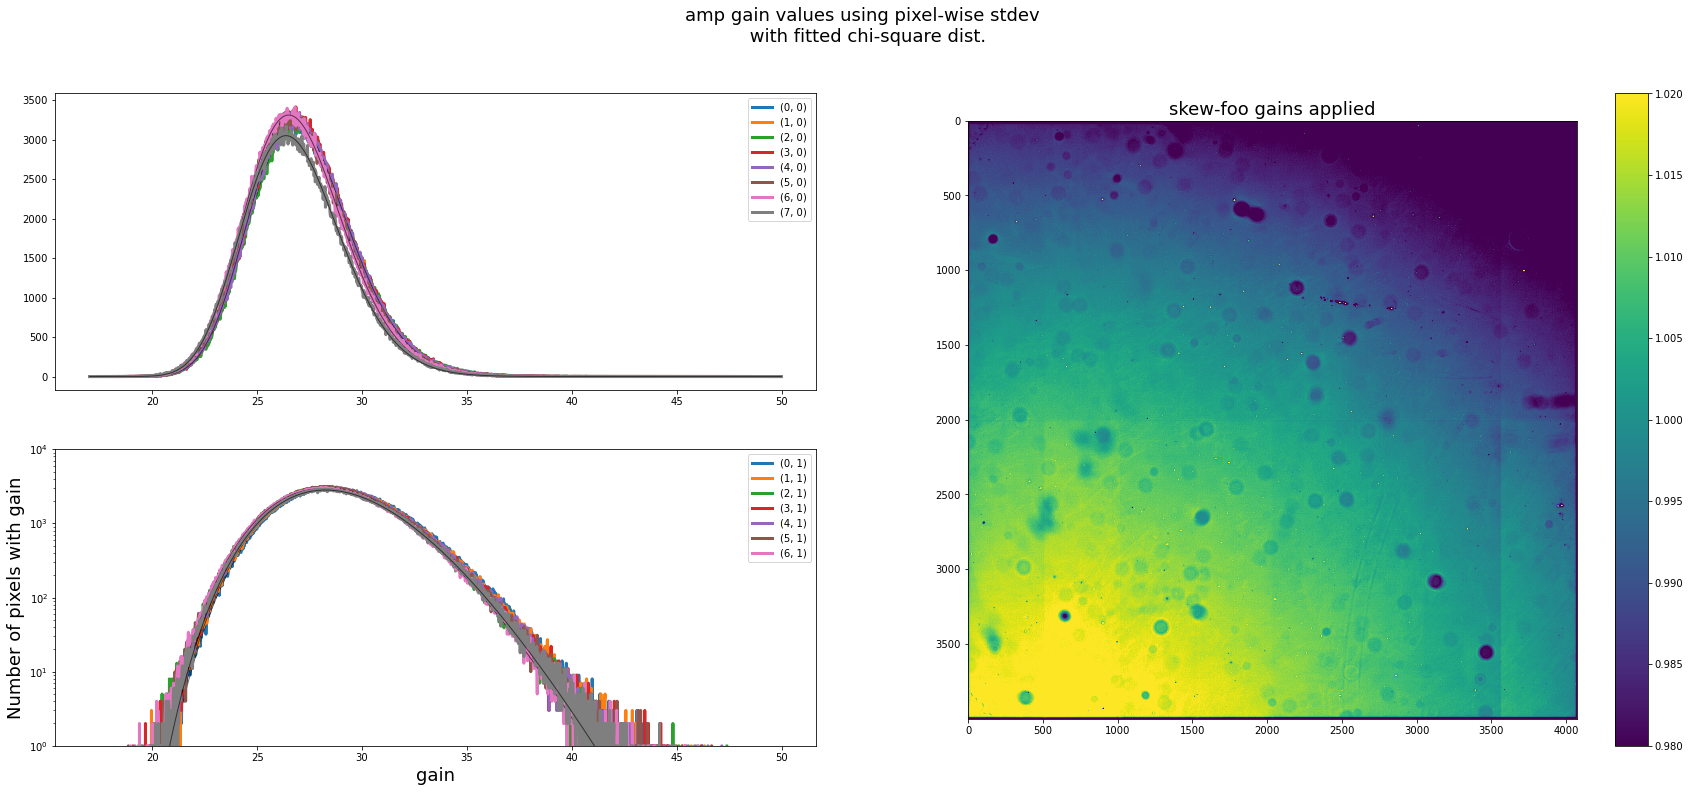

In [10]:
chigains=[]
meanflats=[]
for sensnum in ['S11']:#['S00','S01','S02','S10','S11','S12','S20','S21','S22']:

    meanflat=fits.getdata(rootdir+'master/'+sensnum+'_meanflat.fits')
    #medflat=fits.getdata(rootdir.replace('raw','master')+sensnum+'_medflat.fits')
    stdflat=fits.getdata(rootdir+'master/'+sensnum+'_stdflat.fits')
    stdbias=fits.getdata(rootdir+'master/'+sensnum+'_stdbias.fits')
    #meanbias=fits.getdata(rootdir.replace('raw','master')+sensnum+'_meanbias.fits')
    allmask=fits.getdata(rootdir+'master/'+sensnum+'_mask.fits')
    
    
    plt.figure(figsize=(30,12))
    footitle='amp gain values using pixel-wise stdev \n with fitted chi-square dist.'
    plt.suptitle(footitle,fontsize=fs)
    gainminmax=(17,50)
    crdnoise=0.0


    plt.subplot(121)
    foogains,n,b=gains_from_stdflat_chi(meanflat,stdflat,stdbias,doplots=True,mask=allmask,
                                    gainminmax=gainminmax,crdnoise=crdnoise,nbins=1500)
    foogains_chi2=foogains.copy()
    chigains.append(foogains)
    plt.yscale('log'),plt.ylim(1,1e4)



    plt.ylabel('Number of pixels with gain',fontsize=fs),plt.xlabel('gain',fontsize=fs)

    #medfoo=apply_gains_from_stdflat(fits.getdata(flatlist[24]),foogains)-medbias
    meanfoo=apply_gains_from_stdflat(meanflat,foogains)#-medbias
    meanflats.append(meanfoo)
    
    datfoo=meanfoo

    plt.subplot(122),plt.title('skew-foo gains applied',fontsize=fs)
    mean,med,std=stats.sigma_clipped_stats(datfoo[allmask.astype('bool')])
    datfoo=datfoo/med
    mean,med,std=stats.sigma_clipped_stats(datfoo[allmask.astype('bool')])
    vmin,vmax=.98,1.02#med-std,med+std
    plt.imshow(datfoo,vmin=vmin,vmax=vmax),plt.colorbar()
    plt.savefig(rootdir.replace('raw/',sensnum+'-chigains.png'),dpi=150)

    
    
    #fits.writeto(rootdir.replace('raw/',sensnum+'-meanflat_gaincorrnorm_chi2.fits'),datfoo,overwrite=True)
    #fits.writeto(rootdir.replace('raw/',sensnum+'-meanflat_gaincorr_chi2.fits'),meanfoo,overwrite=True)